## Kaggle赛题-Store Sales-Time Series Forecasting

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/code

In [9]:
import numpy as np 
import pandas as pd 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn
import torch.optim.adam
import seaborn as sns
import sklearn
from sklearn.metrics import mean_squared_error
import os

## 数据集介绍

-holidays_events.csv

-oil.csv

-sample_submission.csv

-stores.csv

-test.csv

-train.csv

-transactions.csv

### train.csv

在train.csv中
每一个货物有这些特征：

store_nbr：所在商店

family：所属商品类型

sales：所属商品类型在货物所在商店当日的销售额

onpromotion：所属商品类型在货物所在商店当日的进货数量

### stores.csv

每一个商店有如下特征：

city：所在城市

state：所在州

type：类型

cluster：聚类

### oil.csv

每天的油价dcoilwtico

### holidays_events.csv

date：日期

type：类型，包括节假日holiday，时间Event等等

locale：事件范围，全国的，本地的等等

locale_name：事件范围的地点，如果是国家性的就对应厄瓜多尔，如果是某个地方的节日就对应某个地方

description：描述，也就是节日的名字

transferred：是否是推迟后的节日。如果是推迟后的，那么就没那么重要了


### transactions.csv

就是每天的交易额

## 数据读取与处理

In [84]:
train_data = pd.read_csv('./data/train.csv')
oil = pd.read_csv('./data/oil.csv')
stores = pd.read_csv('./data/stores.csv')
holiday_event = pd.read_csv('./data/holidays_events.csv')
testdata = pd.read_csv('./data/test.csv')
trans=pd.read_csv('./data/transactions.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1218 non-null   object 
 1   Prices  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


<AxesSubplot:xlabel='date'>

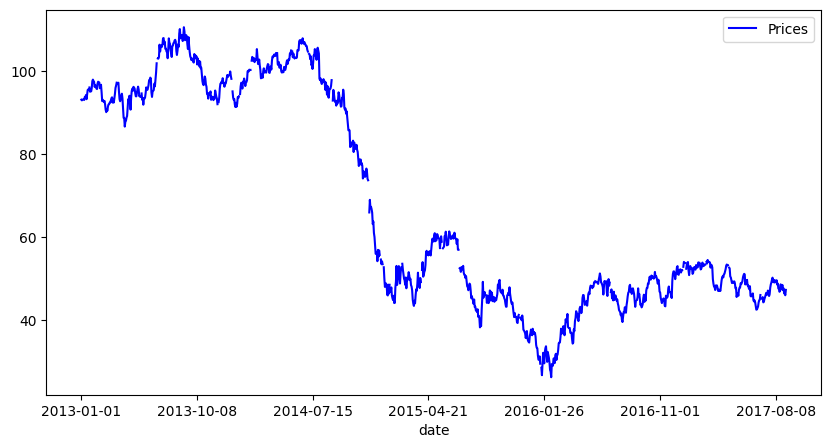

In [11]:
oil1=oil.rename(columns={"dcoilwtico":"Prices"}) #no idea what dcoilwtico is ??
oil1.info() #43 null values in oil prices >> data based on date
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
oil1.plot.line(x="date", y="Prices", color="b", ax=axes, rot=0)

In [12]:
trans.head() #data based on date store number and transaction numbers

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [13]:
holiday_event.loc[holiday_event.type=="Transfer", "description"] = holiday_event.loc[holiday_event.type == "Transfer", "description"].str.replace("Translado", "") 
holiday_event['type'].replace("Transfer", "Normal", inplace = True)
holiday_event.describe

<bound method NDFrame.describe of            date        type    locale locale_name  \
0    2012-03-02     Holiday     Local       Manta   
1    2012-04-01     Holiday  Regional    Cotopaxi   
2    2012-04-12     Holiday     Local      Cuenca   
3    2012-04-14     Holiday     Local    Libertad   
4    2012-04-21     Holiday     Local    Riobamba   
..          ...         ...       ...         ...   
345  2017-12-22  Additional  National     Ecuador   
346  2017-12-23  Additional  National     Ecuador   
347  2017-12-24  Additional  National     Ecuador   
348  2017-12-25     Holiday  National     Ecuador   
349  2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                           

In [14]:
#转换日期
def conv_date(df):
   df['date']=pd.to_datetime(df['date'], format = "%Y-%m-%d")

conv_date(holiday_event)
conv_date(oil1)
conv_date(train_data)
conv_date(testdata)
conv_date(trans)

In [15]:
new_train = train_data.merge(holiday_event, on = 'date', how = 'left')
new_train = new_train.merge(oil1, on = 'date', how = 'left')
new_train = new_train.merge(stores, on = 'store_nbr', how = 'left')
new_train = new_train.merge(trans, on = ['date', 'store_nbr'], how = 'left')

In [16]:
new_train

,id,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,Prices,city,state,type_y,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6,2155.0


([<matplotlib.patches.Wedge at 0x1e3472963a0>,
 [Text(-1.0528190116173233, 0.31870382610995246, 'GROCERY I'),
  Text(0.23883170761159428, -1.0737594774619361, 'BEVERAGES'),
  Text(1.0956847184074774, -0.09733960061725826, 'PRODUCE'),
  Text(0.8198284630823534, 0.7334039072162261, 'CLEANING'),
  Text(0.2610110629931384, 1.0685846831183723, 'DAIRY')],
 [Text(-0.5742649154276308, 0.1738384506054286, '40.6%'),
  Text(0.13027184051541504, -0.5856869877065106, '25.7%'),
  Text(0.5976462100404422, -0.053094327609413586, '14.5%'),
  Text(0.4471791616812836, 0.40003849484521414, '11.5%'),
  Text(0.14236967072353005, 0.5828643726100212, '7.6%')])

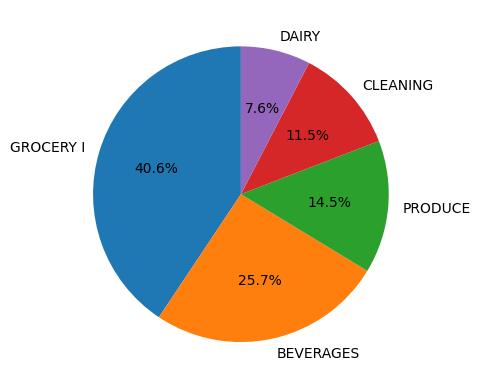

In [17]:
familysales=new_train.groupby('family')['sales'].sum()
family_sales_sorted=familysales.sort_values(ascending=False)
top_families = family_sales_sorted.head(5)
plt.pie(top_families, labels=top_families.index, autopct='%1.1f%%', startangle=90)

,id,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,Prices,city,state,type_y,cluster,transactions
561,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0
562,562,2013-01-01,25,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0
563,563,2013-01-01,25,BEAUTY,2.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0
564,564,2013-01-01,25,BEVERAGES,810.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0
565,565,2013-01-01,25,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0


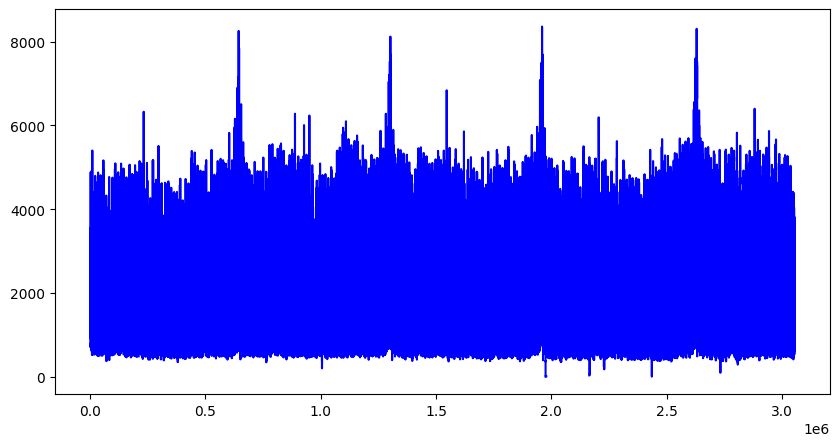

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
new_train['transactions'].plot.line(x="Date", y="Transactions", color="b", ax=axes, rot=0)
new_train["Prices"] = new_train["Prices"].fillna(method = 'bfill')
new_train = new_train[new_train["transactions"].isnull() == False]
new_train.head()

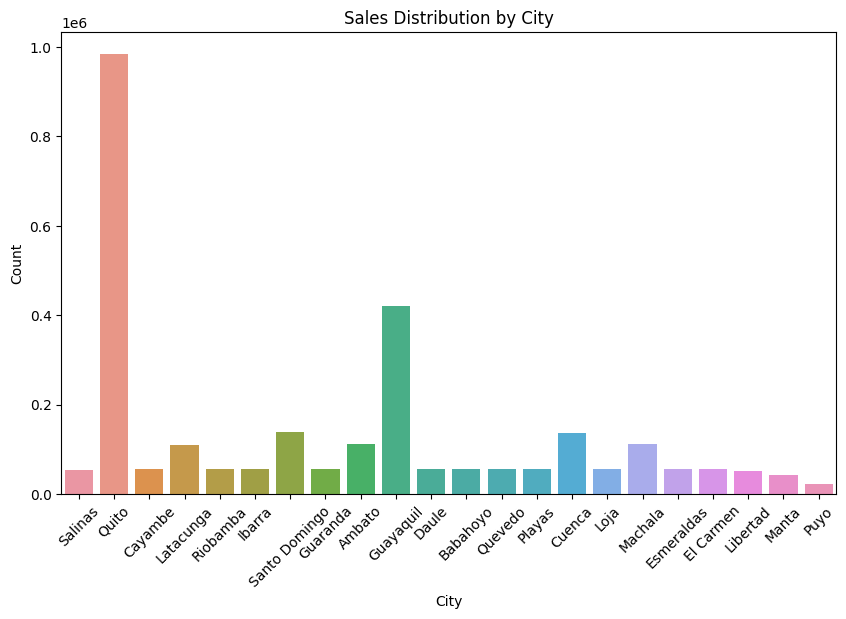

In [19]:
plt.figure(figsize=(10, 6)) 
sns.countplot(data=new_train, x='city') #xhange x with state for state distribution
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Sales Distribution by City')
plt.xticks(rotation=45)
plt.show()

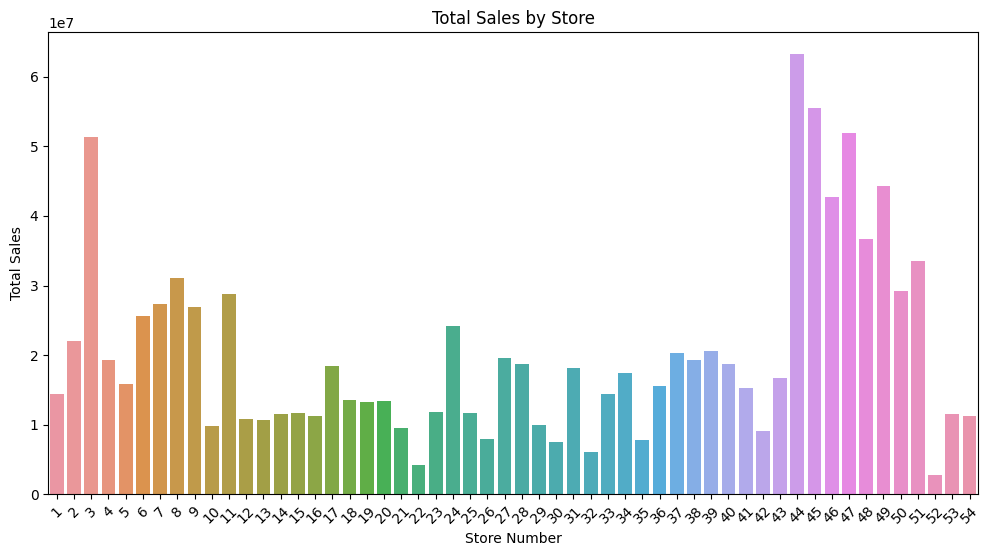

In [20]:
# Calculate the total sales for each store
store_sales = new_train.groupby('store_nbr')['sales'].sum().reset_index()
store_sales = store_sales.sort_values('sales', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=store_sales, x='store_nbr', y='sales')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store')
plt.xticks(rotation=45)
plt.show()

In [21]:
new_train=new_train.rename(columns={'type_x':"holiday_type",'type_y':'store_type'})
new_train['holiday_type'] = new_train['holiday_type'].replace({np.nan : "Normal"})

new_train.head()

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,Prices,city,state,store_type,cluster,transactions
561,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0
562,562,2013-01-01,25,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0
563,563,2013-01-01,25,BEAUTY,2.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0
564,564,2013-01-01,25,BEVERAGES,810.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0
565,565,2013-01-01,25,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,93.14,Salinas,Santa Elena,D,1,770.0


In [22]:
new_train=new_train.drop(['locale_name','description','transferred'],axis=1)
new_train=new_train.drop(['locale','family','city','state','cluster','store_type'],axis=1)

new_train.head()

,id,date,store_nbr,sales,onpromotion,holiday_type,Prices,transactions
561,561,2013-01-01,25,0.0,0,Holiday,93.14,770.0
562,562,2013-01-01,25,0.0,0,Holiday,93.14,770.0
563,563,2013-01-01,25,2.0,0,Holiday,93.14,770.0
564,564,2013-01-01,25,810.0,0,Holiday,93.14,770.0
565,565,2013-01-01,25,0.0,0,Holiday,93.14,770.0


In [23]:
new_train.isnull().sum() #so no null values 
new_train['holiday_type'].unique()

array(['Holiday', 'Normal', 'Work Day', 'Additional', 'Event', 'Bridge'],
      dtype=object)

In [25]:
#using fit transform
from sklearn.preprocessing import OneHotEncoder
column = ["holiday_type"] #column name   
object2 = OneHotEncoder(handle_unknown = "ignore", sparse = False) 
low_card_df = pd.DataFrame(object2.fit_transform(new_train[column])) # creating a seperate Dataframe to hold the encoded values
low_card_df.index = new_train.index #To make sure merging happens correctly
df_encoded = pd.concat([new_train.drop(column, axis = 1), low_card_df], axis=1)
df_encoded.head()

D:\Anaconda\envs\kylinDL2023\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,id,date,store_nbr,sales,onpromotion,Prices,transactions,0,1,2,3,4,5
561,561,2013-01-01,25,0.0,0,93.14,770.0,0.0,0.0,0.0,1.0,0.0,0.0
562,562,2013-01-01,25,0.0,0,93.14,770.0,0.0,0.0,0.0,1.0,0.0,0.0
563,563,2013-01-01,25,2.0,0,93.14,770.0,0.0,0.0,0.0,1.0,0.0,0.0
564,564,2013-01-01,25,810.0,0,93.14,770.0,0.0,0.0,0.0,1.0,0.0,0.0
565,565,2013-01-01,25,0.0,0,93.14,770.0,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
df_encoded.drop('store_nbr',axis=1,inplace=True)
df_encoded.drop('id',axis=1,inplace=True)

In [27]:
df_new=df_encoded.groupby('date').agg(np.mean)

In [28]:
df_new.head()

,sales,onpromotion,Prices,transactions,0,1,2,3,4,5
date,,,,,,,,,,
2013-01-01,76.109667,0.0,93.14,770.000000,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-02,326.806599,0.0,93.14,2026.413043,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-03,238.116753,0.0,92.97,1706.608696,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-04,233.504399,0.0,93.12,1706.391304,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-05,314.459895,0.0,93.20,2034.195652,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
df_new.isnull().sum()
df_new=df_new.astype('float64')
df_new

,sales,onpromotion,Prices,transactions,0,1,2,3,4,5
date,,,,,,,,,,
2013-01-01,76.109667,0.000000,93.14,770.000000,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-02,326.806599,0.000000,93.14,2026.413043,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-03,238.116753,0.000000,92.97,1706.608696,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-04,233.504399,0.000000,93.12,1706.391304,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-05,314.459895,0.000000,93.20,2034.195652,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2017-08-11,463.733851,7.956790,48.81,1658.351852,0.0,0.0,0.0,0.0,1.0,0.0
2017-08-12,444.798280,4.664422,47.59,1665.314815,0.0,0.0,0.0,0.0,1.0,0.0
2017-08-13,485.768618,5.209315,47.59,1592.462963,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
#creating window for series data 
def series_to_labeled(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
  
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)) #input t-n,t-n-1.t-1
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
   
    for i in range(0, n_out):
        cols.append(df.shift(-i))   #Forecasting t,t+1,t+n
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
   
    agg = pd.concat(cols, axis=1)
    agg.columns = names
  
    if dropnan:
        agg.dropna(inplace=True) #drop NaN
    return agg

In [31]:
values=df_new.values
values

array([[ 76.10966664,   0.        ,  93.14      , ...,   1.        ,
          0.        ,   0.        ],
       [326.80659944,   0.        ,  93.14      , ...,   0.        ,
          1.        ,   0.        ],
       [238.11675305,   0.        ,  92.97      , ...,   0.        ,
          1.        ,   0.        ],
       ...,
       [485.76861811,   5.20931538,  47.59      , ...,   0.        ,
          1.        ,   0.        ],
       [427.00471722,   4.51346801,  47.59      , ...,   0.        ,
          1.        ,   0.        ],
       [427.98088437,   5.95117845,  47.57      , ...,   1.        ,
          0.        ,   0.        ]])

In [32]:
#Normalization for fitting in lstm model so that no wight ie tensor produces more affect than other
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))  #range of normalization

scaled_df_split = scaler.fit_transform(values)

window=1
lag=1
series=series_to_labeled(scaled_df_split,window,lag)
series.describe().transpose()
series.drop(series.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
series

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t)
1,0.000000,0.000000,0.792965,0.040153,0.0,0.0,0.0,1.0,0.0,0.0,0.329684
2,0.329684,0.000000,0.792965,0.513847,0.0,0.0,0.0,0.0,1.0,0.0,0.213051
3,0.213051,0.000000,0.790951,0.393274,0.0,0.0,0.0,0.0,1.0,0.0,0.206985
4,0.206985,0.000000,0.792728,0.393192,0.0,0.0,0.0,0.0,1.0,0.0,0.313447
5,0.313447,0.000000,0.793675,0.516781,0.0,0.0,0.0,0.0,0.0,1.0,0.350131
...,...,...,...,...,...,...,...,...,...,...,...
1677,0.380617,0.289281,0.264716,0.329789,0.0,0.0,0.0,1.0,0.0,0.0,0.509753
1678,0.509753,0.518090,0.267914,0.375080,0.0,0.0,0.0,0.0,1.0,0.0,0.484851
1679,0.484851,0.303714,0.253464,0.377705,0.0,0.0,0.0,0.0,1.0,0.0,0.538730
1680,0.538730,0.339194,0.253464,0.350239,0.0,0.0,0.0,0.0,1.0,0.0,0.461451


In [33]:
labels=series['var1(t)']
series=series.drop('var1(t)',axis=1)

In [34]:
l_values = labels.values
s_values = series.values

In [35]:
split_length = 365*3 

X_train = s_values[:split_length]
X_test = s_values[split_length:]
y_train = l_values[:split_length]
y_test = l_values[split_length:]

print("Train shape: ", X_train.shape, y_train.shape)
print("Test shape: ", X_test.shape, y_test.shape)
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)

Train shape:  (1095, 10) (1095,)
Test shape:  (586, 10) (586,)
X_train size:  torch.Size([1095, 1, 10])
X_test size:  torch.Size([586, 1, 10])


In [36]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [40]:
train_dataset

## 构建模型

In [53]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#device ='cpu'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [61]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
train_losses = []
class LSTM_2(nn.Sequential):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        device = x.device 
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size,
                         dtype=torch.float32).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size,
                         dtype=torch.float32).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        device = x.device 
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size,
                         dtype=torch.float32).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size,
                         dtype=torch.float32).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [71]:
model = LSTM_2(10, 100, 10).to(torch.float32)
device = torch.device('cpu')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTM_2(
  (lstm): LSTM(10, 100, num_layers=10, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

## 预备训练

In [72]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
  
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(torch.float32).to(device), batch[1].to(torch.float32).to(device)
        
        output = model(x_batch)
        y_batch = y_batch.view(-1, 1)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index==len(batch): 
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                            avg_loss_across_batches))
            train_losses.append(running_loss/len(batch) )
            running_loss = 0.0
    print()

In [73]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    total_batches = 0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            y_batch = y_batch.view(-1, 1)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            total_batches += 1

    avg_loss_across_batches = running_loss / total_batches
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    val_losses.append(avg_loss_across_batches)
    print()

In [74]:
learning_rate = 0.0001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [75]:
val_losses = []
for epoch in range(num_epochs):
    train_one_epoch()
    val_loss=validate_one_epoch()

Epoch: 1
Batch 3, Loss: 0.006

Val Loss: 0.350

Epoch: 2
Batch 3, Loss: 0.005

Val Loss: 0.341

Epoch: 3
Batch 3, Loss: 0.005

Val Loss: 0.333

Epoch: 4
Batch 3, Loss: 0.005

Val Loss: 0.325

Epoch: 5
Batch 3, Loss: 0.005

Val Loss: 0.316

Epoch: 6
Batch 3, Loss: 0.005

Val Loss: 0.307

Epoch: 7
Batch 3, Loss: 0.005

Val Loss: 0.297

Epoch: 8
Batch 3, Loss: 0.005

Val Loss: 0.287

Epoch: 9
Batch 3, Loss: 0.004

Val Loss: 0.276

Epoch: 10
Batch 3, Loss: 0.004

Val Loss: 0.264

Epoch: 11
Batch 3, Loss: 0.004

Val Loss: 0.251

Epoch: 12
Batch 3, Loss: 0.004

Val Loss: 0.236

Epoch: 13
Batch 3, Loss: 0.003

Val Loss: 0.218

Epoch: 14
Batch 3, Loss: 0.003

Val Loss: 0.196

Epoch: 15
Batch 3, Loss: 0.003

Val Loss: 0.169

Epoch: 16
Batch 3, Loss: 0.002

Val Loss: 0.135

Epoch: 17
Batch 3, Loss: 0.001

Val Loss: 0.093

Epoch: 18
Batch 3, Loss: 0.001

Val Loss: 0.052

Epoch: 19
Batch 3, Loss: 0.001

Val Loss: 0.033

Epoch: 20
Batch 3, Loss: 0.001

Val Loss: 0.044

Epoch: 21
Batch 3, Loss: 0.00

In [76]:
test_loss = 0.0
label1=[]
output1=[]
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
    
        labels = labels.view(-1, 1)
        
        loss = loss_function(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0160


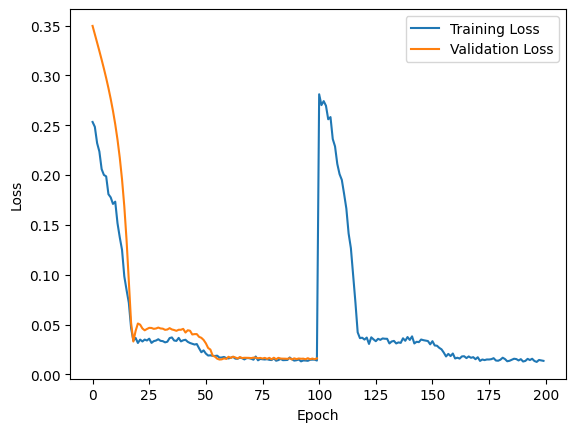

In [77]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [78]:
yhat = model(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

inv_yhat = np.concatenate((yhat.cpu().detach().numpy(), X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 96.286


In [80]:
rmse1 = np.sqrt(np.mean((df2-df1)**2))
print("TEST RMSE : ",rmse1)

TEST RMSE :  0    96.285854
dtype: float64


In [85]:
sample_submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [81]:
sample_submission['sales']=df2
sample_submission

,id,sales
0,3000888,507.308960
1,3000889,400.002747
2,3000890,466.077759
3,3000891,507.953705
4,3000892,528.915955
...,...,...
28507,3029395,NaN
28508,3029396,NaN
28509,3029397,NaN
28510,3029398,NaN


In [82]:
sample_submission.to_csv('LSTM_submission.csv')